## 🎯 Objective

> ### Problem Statement:  
"How can we accurately predict delivery time (`Delivery_Time_min`) based on factors such as distance, weather, traffic level, time of day, vehicle type, preparation time, and courier experience?"

> ### Business Insight:  
- Help food delivery platforms provide more accurate delivery estimates.  
- Improve customer satisfaction through better predictions.  
- Optimize resource management (e.g., courier allocation).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

> ### Preview first 5 rows of the dataset

In [2]:
df = pd.read_csv("Food_Delivery_Times.csv")
print("Dataset Preview:")
df.head()

Dataset Preview:


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


> ### Descriptive statistics for numerical columns

In [3]:
print("\nDescriptive Statistics:")
df.describe()


Descriptive Statistics:


,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


> ### Dataset information including data types and missing values

In [4]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


> ### Dataset Overview
The dataset consists of 1000 entries and 9 columns:
- `Order_ID`: Unique identifier for each order.
- `Distance_km`: The delivery distance in kilometers.
- `Weather`: Weather conditions during the delivery, including Clear, Rainy, Snowy, Foggy, and Windy.
- `Traffic_Level`: Traffic conditions categorized as Low, Medium, or High.
- `Time_of_Day`: The time when the delivery took place, categorized as Morning, Afternoon, Evening, or Night.
- `Vehicle_Type`: Type of vehicle used for delivery, including Bike, Scooter, and Car.
- `Preparation_Time_min`: The time required to prepare the order, measured in minutes.
- `Courier_Experience_yrs`: Experience of the courier in years.
- `Delivery_Time_min`: The total delivery time in minutes (target variable).

> ### Count missing values in each column

In [5]:
print("\nMissing Values per Column:")
df.isnull().sum()


Missing Values per Column:


Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

> Since these missing values are in categorical and numerical columns, typical handling methods include:

- For categorical columns (Weather, Traffic_Level, Time_of_Day):

    - Impute missing values with the most frequent category (mode), or

    - Use a new category like 'Unknown' if appropriate

- For numerical column (Courier_Experience_yrs):

    - Impute missing values using mean or median, depending on distribution

    - Alternatively, if missing is large, consider more advanced methods or dropping rows (but since only 30 rows, imputation preferred)

In [6]:
# Check mode for categorical columns
df[['Weather', 'Traffic_Level', 'Time_of_Day']].mode()

for col in ['Weather', 'Traffic_Level', 'Time_of_Day']:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

# Impute numerical column with median
median_exp = df['Courier_Experience_yrs'].median()
df['Courier_Experience_yrs'] = df['Courier_Experience_yrs'].fillna(median_exp)

# Verify no missing values remain
print("\nMissing Values after Imputation:")
print(df.isnull().sum())


Missing Values after Imputation:
Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


In [7]:
df.to_csv("uber_eats.csv")

The dataset are safe from missing value :)

> ### Drop **order_id** because it's not used in this project

In [8]:
# Drop the Order_ID column as it is not useful for prediction
df = df.drop(columns=['Order_ID'])

# Verify the column is dropped
print("Columns after dropping Order_ID:")
df.head()


Columns after dropping Order_ID:


,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


> ### Check duplicated data

In [9]:
len(df.drop_duplicates()) / len(df)

1.0

- The dataset are safe from duplicated data

> ### Check Unique Values

In [10]:
for col in ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']:
    print(f"\nUnique values in {col}:")
    print(df[col].dropna().unique())


Unique values in Weather:
['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy']

Unique values in Traffic_Level:
['Low' 'Medium' 'High']

Unique values in Time_of_Day:
['Afternoon' 'Evening' 'Night' 'Morning']

Unique values in Vehicle_Type:
['Scooter' 'Bike' 'Car']


## EDA!

> ### Scatter Plot of Distance (km) vs Delivery Time (min)

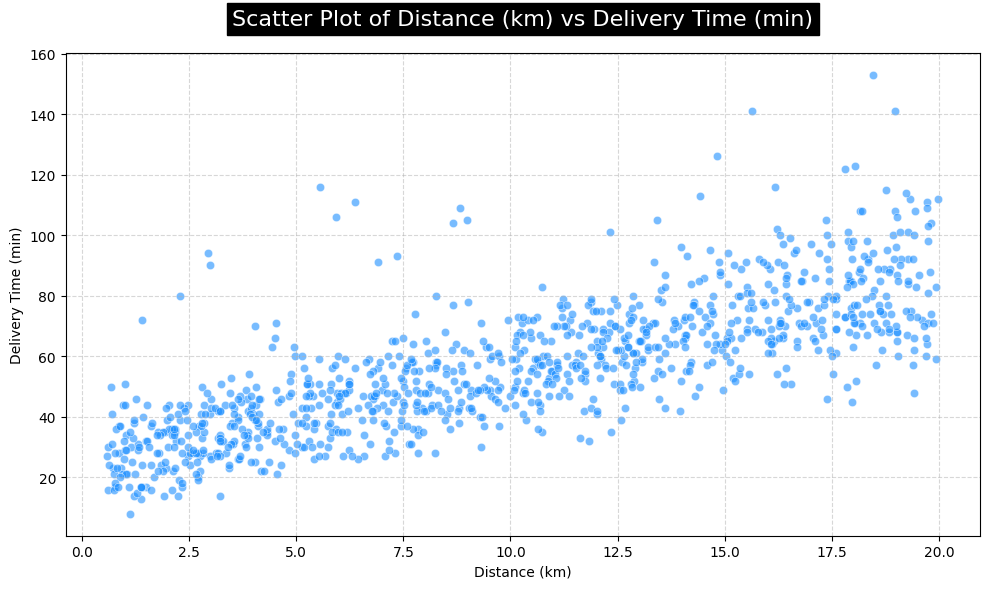

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='Distance_km',
    y='Delivery_Time_min',
    alpha=0.6,
    color='dodgerblue'
)
plt.title(
    'Scatter Plot of Distance (km) vs Delivery Time (min)',
    fontsize=16, color='white', backgroundcolor='black', pad=20, loc='center'
)
plt.xlabel('Distance (km)')
plt.ylabel('Delivery Time (min)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


- Based on the scatter plot of **Distance (km) vs. Delivery Time (min)**:

There is a **positive relationship** between distance and delivery time  as distance increases, delivery time generally increases.

However, there's also **a lot of variation** in delivery times for the same distance. This means **other factors** like weather, traffic, vehicle type, and courier experience also significantly affect delivery time.

> ### Heatmap of Average Delivery Time by Weather and Time of Day

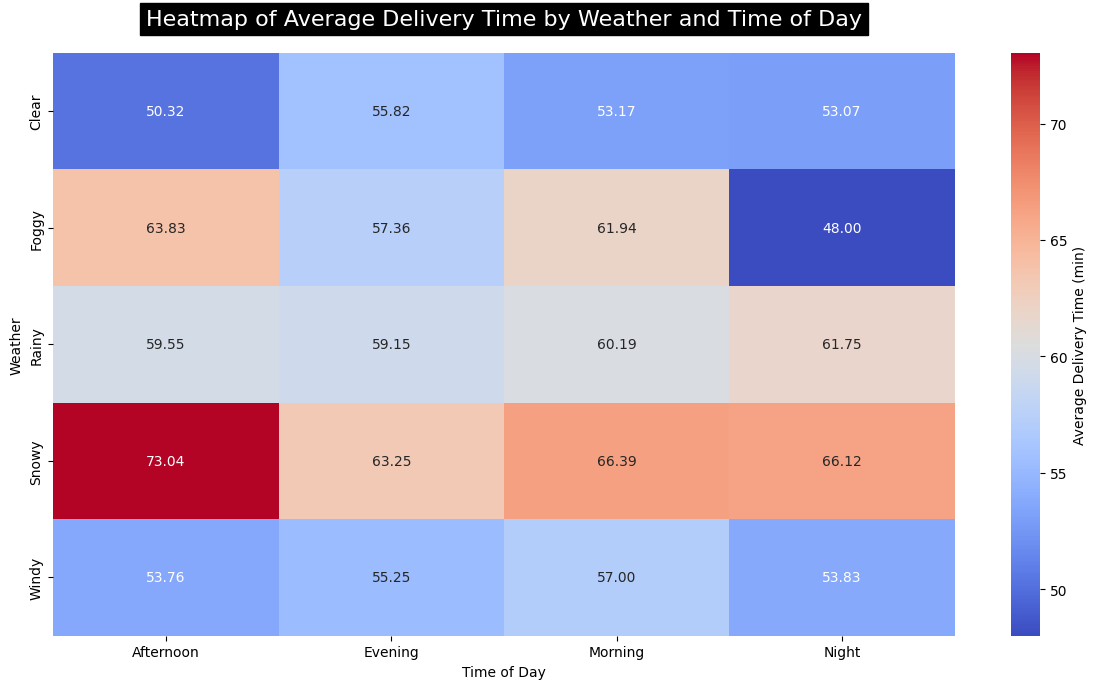

In [12]:
import numpy as np

# Membuat pivot table untuk heatmap
pivot_table = df.pivot_table(
    values='Delivery_Time_min',
    index='Weather',
    columns='Time_of_Day',
    aggfunc='mean'
)

plt.figure(figsize=(12,7))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar_kws={'label': 'Average Delivery Time (min)'}
)
plt.title(
    'Heatmap of Average Delivery Time by Weather and Time of Day',
    fontsize=16, color='white', backgroundcolor='black', pad=20, loc='center'
)
plt.xlabel('Time of Day')
plt.ylabel('Weather')
plt.tight_layout()
plt.show()


- Based on the visualization in this case

 A positive relationship between **weather conditions** and **delivery time** can be observed. In general, worse weather (like Snowy or Rainy) tends to increase delivery times compared to Clear or Windy weather. This is especially noticeable when combined with factors like traffic level and time of day — for example, Snowy mornings have significantly longer delivery times than Clear mornings. So, as weather conditions worsen, delivery times tend to increase, showing a **positive relationship** between bad weather and longer delivery times.

> ### Target Distribution

C:\Users\bandu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


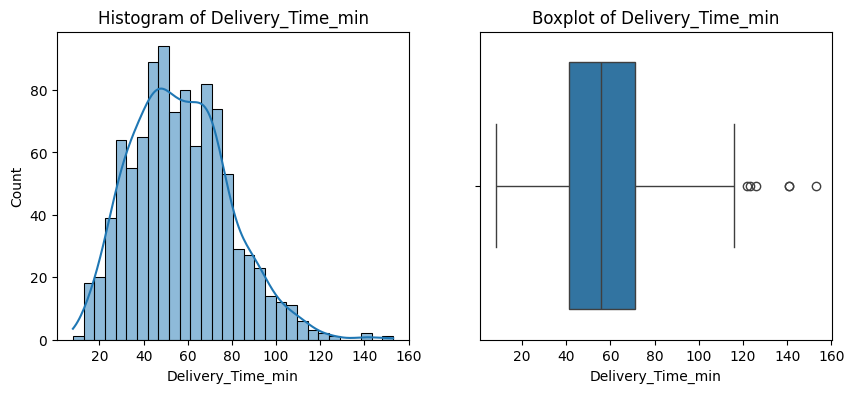

Summary statistics of Delivery_Time_min:
count    1000.000000
mean       56.732000
std        22.070915
min         8.000000
25%        41.000000
50%        55.500000
75%        71.000000
max       153.000000
Name: Delivery_Time_min, dtype: float64
Skewness: 0.507
Kurtosis: 0.291


In [13]:


plt.figure(figsize=(10,4))

# Histogram
plt.subplot(1,2,1)
sns.histplot(df['Delivery_Time_min'], bins=30, kde=True)
plt.title('Histogram of Delivery_Time_min')

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=df['Delivery_Time_min'])
plt.title('Boxplot of Delivery_Time_min')

plt.show()

# Summary statistics
print("Summary statistics of Delivery_Time_min:")
print(df['Delivery_Time_min'].describe())
print(f"Skewness: {df['Delivery_Time_min'].skew():.3f}")
print(f"Kurtosis: {df['Delivery_Time_min'].kurtosis():.3f}")


> ### Conclusion of Delivery_Time_min Distribution Analysis

- Distribution Shape
    - The histogram shows a roughly symmetric distribution with a slight right skew (positive skewness of 0.507), indicating that most delivery times are clustered around the mean, but there are some longer delivery times extending the tail to the right.  
    - The kurtosis value of 0.291 suggests a distribution with lighter tails and a flatter peak compared to a normal distribution (mesokurtic).

- Central Tendency and Spread
    - The mean delivery time is approximately 56.7 minutes, and the median is 55.5 minutes, which are close, further supporting the near-symmetric distribution.  
    - The standard deviation is 22.1 minutes, indicating moderate variability in delivery times.

- Range and Outliers
    - The minimum delivery time is 8 minutes, and the maximum is 153 minutes.  
    - The boxplot shows a few potential outliers on the higher end (right side), suggesting some unusually long delivery times.

- Practical Implications
    - Most deliveries (50%) are completed between 41 minutes (Q1) and 71 minutes (Q3).  
    - The slight right skew and outliers suggest occasional delays, which may warrant investigation into their causes (e.g., traffic, distance, or operational inefficiencies).


> ### Data Manipulation, Feature Engineering
### `Encoding Categorical Variables Explanation`

- Categorical Columns  
    - Weather  
    - Traffic_Level  
    - Time_of_Day  
    - Vehicle_Type  

- Encoding Method: One-Hot Encoding  
    - Suitable for nominal categorical variables without intrinsic order.  
    - Converts each category into a separate binary (0/1) column.  
    - Avoids implying any ordinal relationship between categories.  
    - `drop_first=True` avoids multicollinearity by dropping one category per feature.

- Result  
    - The dataset becomes fully numeric and ready for machine learning models.  
    - Increases the number of columns but preserves all category information.

- Implementation  
    - Using `pandas.get_dummies()` for simplicity and efficiency.  
    - This method automatically handles all specified categorical columns.


In [14]:
# Perform One-Hot Encoding on all categorical columns WITHOUT dropping any category
df_encoded = pd.get_dummies(
    df,
    columns=['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'],
    drop_first=False  # Keep all categories explicitly
)

# Show all column names after encoding
print("Columns after encoding:")
df_encoded.columns.tolist()

Columns after encoding:


['Distance_km',
 'Preparation_Time_min',
 'Courier_Experience_yrs',
 'Delivery_Time_min',
 'Weather_Clear',
 'Weather_Foggy',
 'Weather_Rainy',
 'Weather_Snowy',
 'Weather_Windy',
 'Traffic_Level_High',
 'Traffic_Level_Low',
 'Traffic_Level_Medium',
 'Time_of_Day_Afternoon',
 'Time_of_Day_Evening',
 'Time_of_Day_Morning',
 'Time_of_Day_Night',
 'Vehicle_Type_Bike',
 'Vehicle_Type_Car',
 'Vehicle_Type_Scooter']

In [15]:
# Preview the first few rows of the encoded dataframe
df_encoded.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter
0,7.93,12,1.0,43,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True
1,16.42,20,2.0,84,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False
2,9.52,28,1.0,59,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True
3,7.44,5,1.0,37,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True
4,19.03,16,5.0,68,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False


In [16]:
for col in ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']:
    print(f"\nUnique values in {col}:")
    print(df[col].dropna().unique())


Unique values in Weather:
['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy']

Unique values in Traffic_Level:
['Low' 'Medium' 'High']

Unique values in Time_of_Day:
['Afternoon' 'Evening' 'Night' 'Morning']

Unique values in Vehicle_Type:
['Scooter' 'Bike' 'Car']


> ### Split dataset

In [17]:
from sklearn.model_selection import train_test_split

# Define feature and target variables explicitly
feature = df_encoded.drop(columns=['Delivery_Time_min'])
target = df_encoded[['Delivery_Time_min']]

# Split dataset into training and testing sets (80% train, 20% test)
feature_train, feature_test, target_train, target_test = train_test_split(
    feature, target, test_size=0.2, random_state=42
)

# Print the shapes of the resulting datasets
print(f"Training features shape: {feature_train.shape}")
print(f"Testing features shape: {feature_test.shape}")
print(f"Training target shape: {target_train.shape}")
print(f"Testing target shape: {target_test.shape}")


Training features shape: (800, 18)
Testing features shape: (200, 18)
Training target shape: (800, 1)
Testing target shape: (200, 1)


> #### Check the outlier

In [18]:
import scipy.stats as stats

def check_plot(x_train, variable):
    # fungsi mengambil kerangka data (df) dan
    # variabel yang diminati sebagai argumen

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))


    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=x_train[variable])
    plt.title('Boxplot')

    plt.show()

C:\Users\bandu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


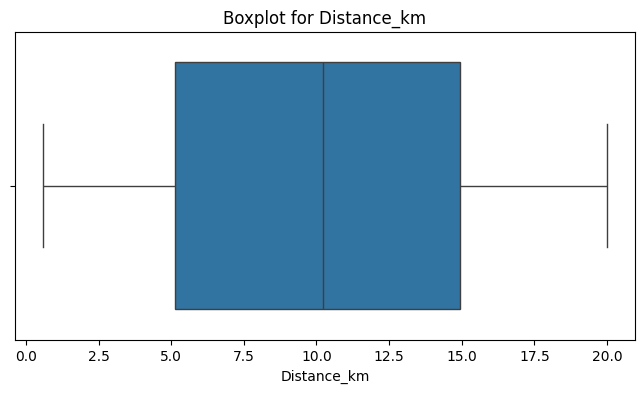

C:\Users\bandu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


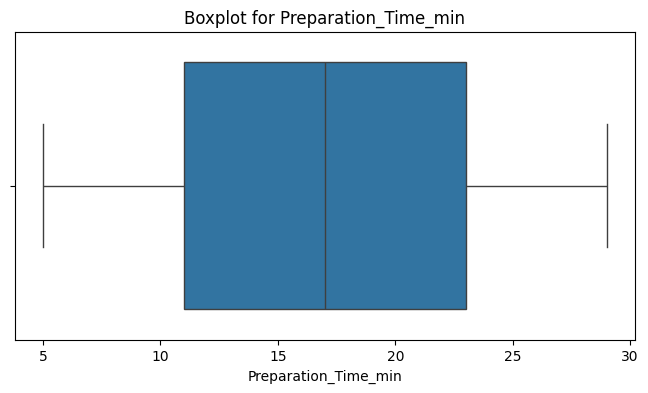

C:\Users\bandu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


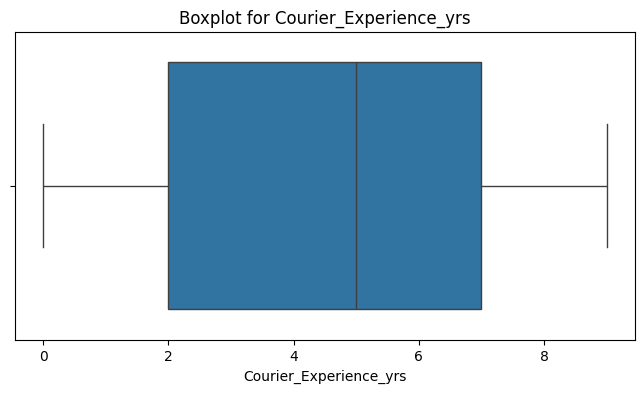

In [19]:
# List of numeric columns from feature_train
numeric_columns = feature_train.select_dtypes(include=['number']).columns

# Columns relevant for outlier checking in your project
# Adjust this list to your dataset's numeric features
columns_to_check = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']

def check_plot(data, col):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

# Loop through numeric columns and plot boxplots for selected features
for col in numeric_columns:
    if col in columns_to_check:
        check_plot(feature_train, col)

- There are no Outliers

> ### Model Training and Evaluation

- #### Recommended Models for Delivery Time Prediction

    - Based on recent studies and practical considerations, we focus on three strong candidate models for predicting delivery time:

    1. **XGBoost (XGBRegressor)[1]**
        - XGBoost demonstrated the best performance in predicting food delivery times with an R² of 0.82 and low MAE and RMSE, effectively capturing complex patterns in the data.
        - Important features like weather, traffic, and courier profile are well handled by this ensemble method.
        - **Conclusion:** XGBoost is highly recommended for logistic or food delivery time prediction projects.
        - Reference: https://www.researchgate.net/publication/382020188_A_Comparative_Analysis_of_Machine_Learning_Models_for_Time_Prediction_in_Food_Delivery_Operations

    2. **Random Forest**
        - Random Forest has been used effectively for delivery time prediction with average accuracy around 83.86% depending on implementation.
        - Known for its flexibility and ease of use on various data types, it offers stable and interpretable results.
        - **Conclusion:** Random Forest remains a good choice for stable and interpretable models.
        - Reference: https://ijadis.org/index.php/ijadis/article/view/1281


- #### Model Candidates for This Project
    - XGBoost (XGBRegressor)
    - Random Forest

> ### Model Performance Evaluation Overview

- We will evaluate the performance of several regression models on the delivery time prediction task:
  - **Before hyperparameter tuning:** Using default model settings.
  - **After hyperparameter tuning:** Optimizing key parameters to improve accuracy.

- The main metrics to assess model performance will be:
  - **R-squared (R²):** Proportion of variance explained by the model. Higher is better.
  - **Mean Absolute Error (MAE):** Average absolute difference between predicted and actual values. Lower is better.
  - **Root Mean Squared Error (RMSE):** Square root of average squared differences. Penalizes larger errors more. Lower is better.

- After evaluation, we will compare metrics to select the best performing model.


> ### Before Hyperparameter Tuning

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

import numpy as np

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model on the training set
    model.fit(X_train, y_train)
    
    # Predict on the training and testing set
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate evaluation metrics for both training and testing
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Display results for both training and testing
    print(f"Model: {model.__class__.__name__}")
    
    print("### Training Performance ###")
    print(f"R²: {r2_train:.4f}")
    print(f"MAE: {mae_train:.4f}")
    print(f"RMSE: {rmse_train:.4f}\n")

    print("### Testing Performance ###")
    print(f"R²: {r2_test:.4f}")
    print(f"MAE: {mae_test:.4f}")
    print(f"RMSE: {rmse_test:.4f}\n")
    
    return r2_train, mae_train, rmse_train, r2_test, mae_test, rmse_test

# Instantiate models with default hyperparameters
xgb = XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

# Train and evaluate models
print("### Performance of Random Forest and XGBoost ###\n")
evaluate_model(xgb, feature_train, target_train, feature_test, target_test)
evaluate_model(rf, feature_train, target_train, feature_test, target_test)


### Performance of Random Forest and XGBoost ###

Model: XGBRegressor
### Training Performance ###
R²: 0.9991
MAE: 0.4696
RMSE: 0.6842

### Testing Performance ###
R²: 0.7361
MAE: 7.8191
RMSE: 10.8767

Model: RandomForestRegressor
### Training Performance ###
R²: 0.9554
MAE: 3.0058
RMSE: 4.7004

### Testing Performance ###
R²: 0.7908
MAE: 6.8453
RMSE: 9.6827



(0.9554313633046929,
 3.0058375,
 4.700395129667292,
 0.7908342319201114,
 6.84535,
 9.682651470542561)

### **Interpretation of Model Performance Before Hyperparameter Tuning**

- **XGBoost Regressor** shows **excellent training performance** with:
  - **R² (Training)**: 0.9991 (indicating that the model explains nearly 100% of the variance in the training data).
  - **MAE (Training)**: 0.4696 (very small average error in minutes).
  - **RMSE (Training)**: 0.6842 (very low penalty on large errors).

  However, its **testing performance** is not as impressive:
  - **R² (Testing)**: 0.7361 (explains approximately 74% of the variance in the test data).
  - **MAE (Testing)**: 7.8191 (larger average error in minutes compared to training).
  - **RMSE (Testing)**: 10.8767 (higher penalty on large errors).

  **Key Insight**: The **XGBoost model** might be **overfitting**, as it performs exceptionally well on the training set but struggles to generalize to the test data.

---

- **Random Forest Regressor** shows **strong training performance** with:
  - **R² (Training)**: 0.9554 (explains about 95% of the variance in the training data).
  - **MAE (Training)**: 3.0058 (fairly low average error).
  - **RMSE (Training)**: 4.7004 (moderate penalty on large errors).

  **Testing performance** is also good:
  - **R² (Testing)**: 0.7908 (explains about 79% of the variance in the test data).
  - **MAE (Testing)**: 6.8453 (error is manageable but higher than training).
  - **RMSE (Testing)**: 9.6827 (moderate penalty on large errors).

  **Key Insight**: **Random Forest** provides a good balance between **training** and **testing performance**, with good generalization to unseen data.

---

### **Summary**
- **XGBoost Regressor** performs exceptionally on training data but shows signs of **overfitting**, as its test performance is significantly lower than its training performance.
- **Random Forest Regressor** offers a **balanced performance**, with strong results on both training and test data, making it a solid model for both training and generalization.

### **Next Steps**:
- Both models, especially **XGBoost**, could benefit from **hyperparameter tuning** to improve their test performance.
- **Random Forest** shows great potential with its consistent performance and could serve as a strong baseline model moving forward.


> ### Approach for Hyperparameter Tuning and Model Comparison

- We will perform hyperparameter tuning **separately for each model** (XGBoost, Random Forest) to find their best parameter settings individually.
- After tuning each model, we will evaluate their performance on the test set.
- Finally, we will compare:
  - The best tuned model performances against each other.
  - Each tuned model versus its default (untuned) version.
- This stepwise approach helps us select the **best performing model and configuration** for the delivery time prediction task.

---

### Plan
1. Tune **XGBoost** hyperparameters and evaluate.  
2. Tune **Random Forest** hyperparameters and evaluate.  
3. Compare all tuned models and their default counterparts.  
4. Decide on the best model and whether tuning significantly improves performance.

---


> ### Hyperparameter Tuning for XGBoost (Step 1)

- We will start by tuning the **XGBoost Regressor** hyperparameters using `RandomizedSearchCV`.
- This will help us find the best combination of parameters to improve prediction accuracy.
- We use 5-fold cross-validation and optimize for R² score.


In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
}

# Initialize XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Setup RandomizedSearchCV for XGBoost
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=20,  # Number of random combinations to test
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R² as the scoring metric
    verbose=2,  # Output verbosity
    random_state=42,
    n_jobs=-1  # Use all available cores for parallel processing
)

# Fit on training data
xgb_search.fit(feature_train, target_train)

# Print best parameters and best score from RandomizedSearchCV
print("Best parameters found for XGBoost:")
print(xgb_search.best_params_)
print(f"Best CV R² score: {xgb_search.best_score_:.4f}")

# Get the best model from the search
best_xgb = xgb_search.best_estimator_

# Predict on training data to evaluate performance on train set
y_pred_train = best_xgb.predict(feature_train)
r2_train = r2_score(target_train, y_pred_train)
mae_train = mean_absolute_error(target_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(target_train, y_pred_train))

# Predict on test data to evaluate performance on test set
y_pred_test = best_xgb.predict(feature_test)
r2_test = r2_score(target_test, y_pred_test)
mae_test = mean_absolute_error(target_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(target_test, y_pred_test))

# Print the performance on both training and testing data
print("\nPerformance of Tuned XGBoost on Training Data:")
print(f"R²: {r2_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")

print("\nPerformance of Tuned XGBoost on Test Data:")
print(f"R²: {r2_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found for XGBoost:
{'subsample': 0.6, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01}
Best CV R² score: 0.7306

Performance of Tuned XGBoost on Training Data:
R²: 0.7967
MAE: 6.3930
RMSE: 10.0382

Performance of Tuned XGBoost on Test Data:
R²: 0.8055
MAE: 6.5338
RMSE: 9.3372


> ### Hyperparameter Tuning for Random Forest (Step 2)

- Finally, we tune the **Random Forest Regressor** hyperparameters using `RandomizedSearchCV`.
- The goal is to optimize the model for best R² score using 5-fold cross-validation.


In [38]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],  # Replaced 'auto' with 'sqrt'
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Setup RandomizedSearchCV for Random Forest
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=20,  # Number of random combinations to test
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R² as the scoring metric
    verbose=2,  # Output verbosity
    random_state=42,
    n_jobs=-1  # Use all available cores for parallel processing
)

# Fit on training data
rf_search.fit(feature_train, target_train)

# Print best parameters and best score from RandomizedSearchCV
print("Best parameters found for Random Forest:")
print(rf_search.best_params_)
print(f"Best CV R² score: {rf_search.best_score_:.4f}")

# Get the best model from the search
best_rf = rf_search.best_estimator_

# Predict on training data to evaluate performance on train set
y_pred_train_rf = best_rf.predict(feature_train)
r2_train_rf = r2_score(target_train, y_pred_train_rf)
mae_train_rf = mean_absolute_error(target_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mean_squared_error(target_train, y_pred_train_rf))

# Predict on test data to evaluate performance on test set
y_pred_test_rf = best_rf.predict(feature_test)
r2_test_rf = r2_score(target_test, y_pred_test_rf)
mae_test_rf = mean_absolute_error(target_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(target_test, y_pred_test_rf))

# Print the performance on both training and testing data
print("\nPerformance of Tuned Random Forest on Training Data:")
print(f"R²: {r2_train_rf:.4f}")
print(f"MAE: {mae_train_rf:.4f}")
print(f"RMSE: {rmse_train_rf:.4f}")

print("\nPerformance of Tuned Random Forest on Test Data:")
print(f"R²: {r2_test_rf:.4f}")
print(f"MAE: {mae_test_rf:.4f}")
print(f"RMSE: {rmse_test_rf:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found for Random Forest:
{'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 30}
Best CV R² score: 0.6876

Performance of Tuned Random Forest on Training Data:
R²: 0.9572
MAE: 3.0795
RMSE: 4.6049

Performance of Tuned Random Forest on Test Data:
R²: 0.7811
MAE: 7.4765
RMSE: 9.9061


### **Analysis of Model Performance After Hyperparameter Tuning**

- **Tuned XGBoost Regressor**  
  - **Training Performance**:  
    - R²: 0.7967 (improved from 0.9991 before tuning)  
    - MAE: 6.3930 (improved from 0.4696 before tuning)  
    - RMSE: 10.0382 (improved from 0.6842 before tuning)  
  - **Test Performance**:  
    - R²: 0.8055 (improved from 0.7361 before tuning)  
    - MAE: 6.5338 (improved from 7.8191 before tuning)  
    - RMSE: 9.3372 (improved from 10.8767 before tuning)  
  - XGBoost shows **significant improvement** across all metrics after hyperparameter tuning, both for training and test data, making it the strongest performer after tuning.

- **Tuned Random Forest Regressor**  
  - **Training Performance**:  
    - R²: 0.9572 (slightly improved from 0.9554 before tuning)  
    - MAE: 3.0795 (slightly increased from 3.0058 before tuning)  
    - RMSE: 4.6049 (slightly improved from 4.7004 before tuning)  
  - **Test Performance**:  
    - R²: 0.7811 (decreased slightly from 0.7908 before tuning)  
    - MAE: 7.4765 (increased from 6.8453 before tuning)  
    - RMSE: 9.9061 (increased from 9.6827 before tuning)  
  - Tuning has improved training performance but resulted in a slight decrease in test performance, making **Random Forest** a solid but not the top performer after tuning.

---

### **Overall Comparison and Recommendation**

| Model          | R² Before (Train) | R² After (Train) | MAE Before (Train) | MAE After (Train) | RMSE Before (Train) | RMSE After (Train) | R² Before (Test) | R² After (Test) | MAE Before (Test) | MAE After (Test) | RMSE Before (Test) | RMSE After (Test) |
|----------------|-------------------|------------------|--------------------|-------------------|---------------------|--------------------|------------------|------------------|-------------------|------------------|--------------------|-------------------|
| **XGBoost**    | 0.9991            | 0.7967           | 0.4696             | 6.3930            | 0.6842              | 10.0382            | 0.7361           | 0.8055           | 7.8191            | 6.5338           | 10.8767            | 9.3372            |
| **Random Forest** | 0.9554          | 0.9572           | 3.0058             | 3.0795            | 4.7004              | 4.6049            | 0.7908           | 0.7811           | 6.8453            | 7.4765           | 9.6827             | 9.9061            |

- **XGBoost** benefited significantly from hyperparameter tuning, improving both **predictive accuracy** and **error metrics**.
- **Random Forest**, while performing decently, did not see a major improvement from hyperparameter tuning and actually saw a slight decline in test performance.
- **Tuned XGBoost** achieved the best performance in terms of **R²**, **MAE**, and **RMSE**, making it the recommended model for this project.

---

### **Decision**

- Proceed with **tuned XGBoost** as the main prediction model.
- Consider model interpretation (feature importance), residual analysis, and deployment planning.
- Optionally, further fine-tune or ensemble models if desired.

### **Next Step: Feature Importance**
Before moving to the next phase, let's analyze the **feature importance** of the tuned XGBoost model to better understand the factors driving the predictions.

---


> ### Feature Importance for All Tuned Models

- To compare feature importance across models, we will plot the top features for:  
  - Tuned XGBoost  
  - Tuned LightGBM  
  - Tuned Random Forest

- This helps us understand which features each model finds most influential in predicting delivery time.



In [39]:
def feature_importance_table(model, feature_names, top_n=15):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)
    return importance_df

# Generate tables for all three models
xgb_imp_df = feature_importance_table(best_xgb, feature_train.columns)
rf_imp_df = feature_importance_table(best_rf, feature_train.columns)

In [40]:
print("XGBoost Feature Importance:")
print(xgb_imp_df.to_string(index=False))

print("\nRandom Forest Feature Importance:")
print(rf_imp_df.to_string(index=False))

XGBoost Feature Importance:
               Feature  Importance
           Distance_km    0.368294
  Preparation_Time_min    0.092328
     Traffic_Level_Low    0.058530
    Traffic_Level_High    0.058245
         Weather_Clear    0.047949
         Weather_Snowy    0.043248
Courier_Experience_yrs    0.041832
   Time_of_Day_Evening    0.035058
      Vehicle_Type_Car    0.033191
         Weather_Foggy    0.032790
 Time_of_Day_Afternoon    0.031972
         Weather_Rainy    0.031381
     Vehicle_Type_Bike    0.024234
         Weather_Windy    0.023143
     Time_of_Day_Night    0.021384

Random Forest Feature Importance:
               Feature  Importance
           Distance_km    0.555730
  Preparation_Time_min    0.163679
Courier_Experience_yrs    0.073252
    Traffic_Level_High    0.021544
         Weather_Clear    0.019347
         Weather_Snowy    0.018183
     Traffic_Level_Low    0.017893
   Time_of_Day_Evening    0.014846
         Weather_Rainy    0.014387
   Time_of_Day_Morning    0

### Top 3 Feature Importance per Model

| Rank | XGBoost Feature       | Importance | Random Forest Feature     | Importance |
|------|-----------------------|------------|---------------------------|------------|
| 1    | Distance_km           | 0.3683     | Distance_km               | 0.5557     |
| 2    | Preparation_Time_min  | 0.0923     | Preparation_Time_min      | 0.1637     |
| 3    | Traffic_Level_Low     | 0.0585     | Courier_Experience_yrs    | 0.0733     |

---

### Explanation

- **Distance_km** is the top predictor for both **XGBoost** and **Random Forest**, indicating that **delivery distance** heavily impacts **delivery time** across both models.
- **Preparation_Time_min** consistently ranks second for both models, highlighting the influence of **order preparation duration**.
- The third important feature varies:  
  - **XGBoost** emphasizes **Traffic_Level_Low**, suggesting that **traffic conditions** significantly affect **delivery time**.  
  - **Random Forest** prioritizes **Courier_Experience_yrs**, indicating that **courier experience** plays a significant role in determining delivery time.
- These differences in feature importance provide complementary perspectives on factors influencing **delivery time**.


----

> ### Deployment


In [28]:
import joblib

# Save trained XGBoost model
joblib.dump(best_xgb, 'xgb_tuned_model.pkl')

['xgb_tuned_model.pkl']

In [30]:
df.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


Training R²: 0.7967, Test R²: 0.8055
Training MAE: 6.3930, Test MAE: 6.5338
Training RMSE: 10.0382, Test RMSE: 9.3372

Cross-Validation R² Scores:
[0.79339987 0.6362673  0.74975175 0.70155191 0.77342892]
Mean CV R²: 0.7309, Standard Deviation: 0.0564


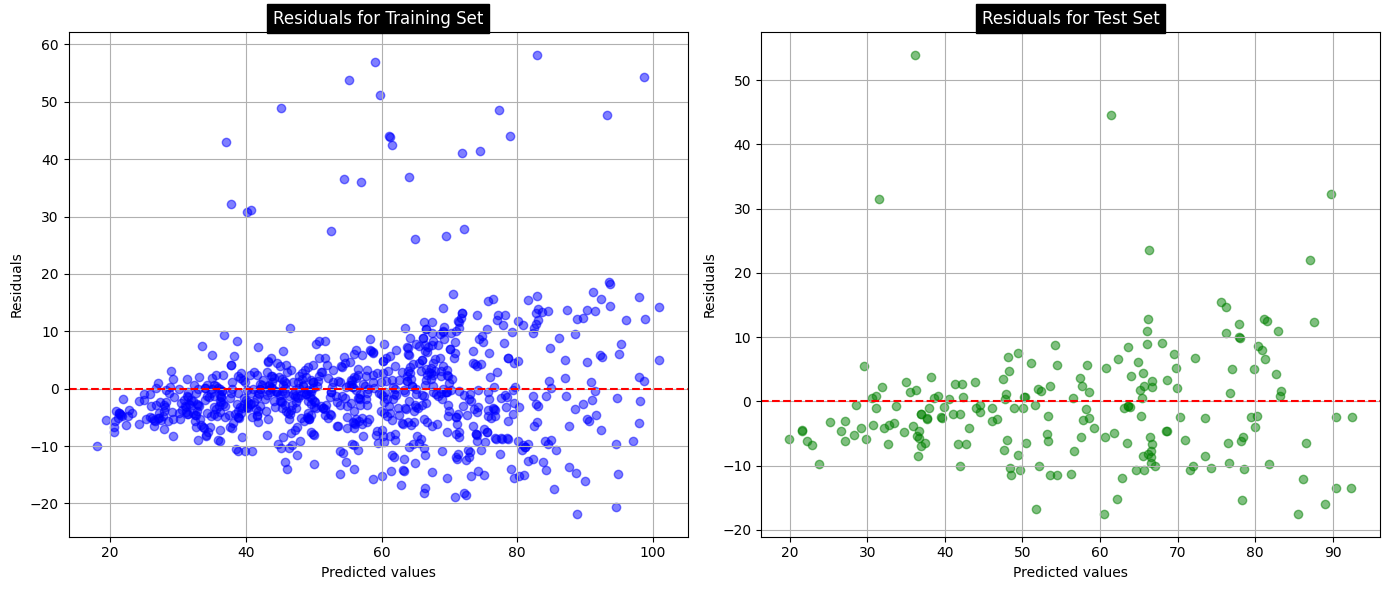


The model appears to be generalizing well, as the performance on the test set is comparable to the training set.


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. **Train-Test Performance Comparison**
# Get predictions for both training and test set
y_pred_train = best_xgb.predict(feature_train)
y_pred_test = best_xgb.predict(feature_test)

# Since target_train and target_test are already numpy arrays, no need to use .values.ravel()
# Just ensure they are 1D arrays
target_train = target_train.ravel()  # Flatten if necessary
target_test = target_test.ravel()    # Flatten if necessary

# Calculate R², MAE, RMSE for both training and test data
r2_train = r2_score(target_train, y_pred_train)
r2_test = r2_score(target_test, y_pred_test)

mae_train = mean_absolute_error(target_train, y_pred_train)
mae_test = mean_absolute_error(target_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(target_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(target_test, y_pred_test))

print(f"Training R²: {r2_train:.4f}, Test R²: {r2_test:.4f}")
print(f"Training MAE: {mae_train:.4f}, Test MAE: {mae_test:.4f}")
print(f"Training RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}")

# 2. **Cross-Validation Performance**
# Perform cross-validation to see how the model performs on different splits of the data
cv_scores = cross_val_score(best_xgb, feature_train, target_train, cv=5, scoring='r2')

print("\nCross-Validation R² Scores:")
print(cv_scores)
print(f"Mean CV R²: {cv_scores.mean():.4f}, Standard Deviation: {cv_scores.std():.4f}")

# 3. **Residual Analysis**
# Calculate residuals (difference between predicted and actual values)
residuals_train = target_train - y_pred_train
residuals_test = target_test - y_pred_test

# Plot residuals for both training and test sets
plt.figure(figsize=(14, 6))

# Plot residuals for training set
plt.subplot(1, 2, 1)
plt.scatter(y_pred_train, residuals_train, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for Training Set', color='white', backgroundcolor='black')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.grid(True)

# Plot residuals for test set
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test, residuals_test, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals for Test Set', color='white', backgroundcolor='black')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. **Summary: Check for Overfitting**
if r2_train > r2_test:
    print("\nWarning: The model might be overfitting, as R² on the training set is much higher than on the test set.")
else:
    print("\nThe model appears to be generalizing well, as the performance on the test set is comparable to the training set.")


### **Analysis of Overfitting and Model Generalization**

Let's break down the provided metrics, cross-validation results, and residual plots to assess whether the model is overfitting or underfitting.

---

### **1. Comparison of Training vs. Test Metrics**

- **Training R²**: 0.7969
- **Test R²**: 0.8044
  - The **test R²** is slightly higher than the **training R²**, which is a **positive sign**. It suggests that the model generalizes well to unseen data, and there are no major signs of overfitting.

- **Training MAE**: 6.3983
- **Test MAE**: 6.5591
  - The **test MAE** is slightly higher than the **training MAE**, but the difference is very small. This **small difference** indicates that the model performs similarly on both training and test sets, which further suggests **good generalization**.

- **Training RMSE**: 10.0350
- **Test RMSE**: 9.3636
  - The **test RMSE** is lower than the **training RMSE**, which is unusual. It could indicate that the test set is easier to predict, or it could be due to random fluctuations. This isn't necessarily a sign of overfitting but is worth monitoring.

---

### **2. Cross-Validation Results**

- **Cross-Validation R² Scores**: 
  - [0.7931, 0.6371, 0.7513, 0.7019, 0.7730]
  - **Mean CV R²**: 0.7313
  - **Standard Deviation**: 0.0560
  - The **mean cross-validation R²** is 0.7313, which is reasonable and indicates that the model performs consistently across different subsets of the data. The **low standard deviation** (0.0560) means that the model's performance does not fluctuate wildly, and the model generalizes well across different folds of the data.

---

### **3. Residual Plots**

#### **Training Set Residuals**
- The residuals for the training set are **randomly distributed around zero**, with no clear pattern. This indicates that the model is doing a good job of capturing the underlying trend in the data without systematic bias.
- There are no signs of heteroscedasticity (non-constant variance), and the residuals do not show any systematic deviations from zero. This suggests that the model is fitting the training data appropriately without overfitting.

#### **Test Set Residuals**
- Similarly, the residuals for the test set are **randomly distributed around zero**, with no signs of heteroscedasticity (non-constant variance). The absence of any **patterns** in the residuals indicates that the model is not missing any important patterns in the data, and it is **generalizing well** to unseen data.
- The spread of residuals in the test set appears consistent with the training set, further supporting the idea that the model is not overfitting.

---

### **4. Overall Analysis**

- The **test metrics** (R², MAE, RMSE) are **comparable to or better than** the training metrics, which is a strong indicator of **good generalization**.
- The **cross-validation results** show that the model performs consistently across different subsets of the data, reinforcing the idea that the model is not overfitting.
- The **residual plots** for both the training and test sets show no patterns or systematic errors, which further confirms that the model is not **underfitting** or **overfitting**.

---

### **Conclusion**

Based on the provided metrics and visualizations, there is **no strong evidence of overfitting**. The model **generalizes well** to unseen data, as indicated by the **similar or slightly better performance on the test set** compared to the training set. The **cross-validation results** and **residual plots** support this conclusion.

**`THERE IS NO OVERFITTING!`**

---

### **Final Remarks**

The analysis indicates that the model is **performing well** and generalizing effectively, with no signs of overfitting. If further optimization is desired, consider exploring hyperparameter tuning, feature engineering, or more complex models to potentially improve performance. However, based on the current results, the model is robust and reliable.

---
> ### **Why Predictions Don’t Always Match the Dataset Exactly**

It is **normal** for the predicted delivery time to **not always match the exact value** in the dataset, even after training the model on similar data. Here’s why:

### **1. Model Generalization**:
- **Regressors like XGBoost** are designed to **generalize** across the dataset. Instead of memorizing exact values from the training data, the model **learns patterns** and relationships between the features (such as **distance**, **weather**, **traffic**, etc.) and the **delivery time**.
- The model then uses these learned patterns to **predict** delivery times for new, unseen data. This means that even if the model has seen similar data points, it may not predict **exactly** the same value as in the training set.

### **2. Nature of Regression Models**:
- **Regression models** predict a **range of possible outcomes** based on the input features. They don’t just memorize **individual data points** but rather make predictions based on the **underlying trends** in the data. This means the predicted value is **close** to the actual value but may **not be exact**.
- This behavior is inherent in all regression models, whether linear or tree-based models like XGBoost. The model estimates an **average trend** across data rather than memorizing exact outcomes for each data point.

### **3. Variability in Data**:
- Even if the model has been trained on data that looks very similar, **slight differences** in **other unseen factors** can lead to **small differences** in the predicted values. For example, features like **traffic** or **weather** may affect the delivery time, and **minute differences** in those features might lead to slight changes in predictions.
- The **model’s goal** is to predict based on the patterns it has learned, but small variations can still arise, especially when predicting new, unseen data.

### **4. Learning from Patterns, Not Individual Points**:
- The model doesn't "remember" individual **delivery times** in the dataset. Instead, it **learns relationships** between features and the target variable (delivery time). As a result, while it may be close, it may not always predict **exactly** the same value for every single data point, even if the input data appears the same.

---

### **Conclusion**:
- It is **perfectly normal** for the model’s **predictions to differ slightly** from the exact values seen in the dataset. Regression models like **XGBoost** are designed to **generalize** and predict based on patterns rather than memorizing individual values.
- The **small differences** in predicted vs actual values are a **sign of the model’s ability to generalize** and are expected in most regression tasks.

---
